In [24]:
import scipy
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import os
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve,precision_recall_curve, auc,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from catboost import CatBoostClassifier

from xgboost import XGBClassifier

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras import layers

In [25]:
import config as cf

In [26]:
list_file_patient_label = cf.list_file_patient_label


dict_patient_files = {
    "list_file_patient_data_5Bands":cf.list_file_patient_data_5Bands,
    "list_file_patient_data_2hz":cf.list_file_patient_data_2hz,
    "list_file_patient_data_EOG_features":cf.list_file_patient_data_EOG_features,
    "list_file_patient_data_eeg_forehead_2hz":cf.list_file_patient_data_eeg_forehead_2hz,
    "list_file_patient_data_eeg_forehead_5bands":cf.list_file_patient_data_eeg_forehead_5bands}

In [27]:
def process_patient_feature(file,eog):
    data=scipy.io.loadmat(file)
    transformations_performed = [element for element in data.keys() if not "__" in element]
    all_feature_ = []
    if not eog:
        #print('here')
        for transformation in transformations_performed:
            feature_data = data[transformation]
            #print(feature_data.shape,"ff")
            channels,sample_number,frequency_bands = feature_data.shape
            #print(feature_data.shape)!
            feature_data=feature_data.reshape(sample_number,channels*frequency_bands)

            all_feature_.append(feature_data)
    else:
        for transformation in transformations_performed:
            #print("hi")
            feature_data = data[transformation]
            all_feature_.append(feature_data)
        
    #print(np.array(all_feature_).shape)
    patient_feature = np.concatenate(all_feature_,axis=-1)
    #print(patient_feature.shape)
    return patient_feature

In [28]:
def create_labels(labels):
    list_class=labels.copy()
    for i,e in enumerate(list_class):
        #print(i)
        if e<0.35:
            list_class[i]=0
        elif e >=0.35 and e<0.70:
            list_class[i]=1
        else:
            list_class[i]=2
    return list_class

In [29]:
def min_max_scale(s):
    return (s - s.min()) / (s.max() - s.min())

In [30]:
def pre_pro_features(lst_patient,eog):
    if eog:
        all_patient_features = np.array([process_patient_feature(file,eog=eog) for file in lst_patient])
    all_patient_features = np.array([process_patient_feature(file,eog=eog) for file in lst_patient])
    return all_patient_features

In [31]:
keys=dict_patient_files.keys()
features_eog = [pre_pro_features(dict_patient_files[key],eog=True) for key in keys if "EOG" in key]
features_eog = np.array(features_eog)[0]
features_eog = features_eog.reshape(features_eog.shape[0]*features_eog.shape[1],features_eog.shape[2])
features_eog.shape


(20355, 108)

In [32]:
features_eeg = [pre_pro_features(dict_patient_files[key],eog=False) for key in keys if "5bands" in key]
features_eeg = np.concatenate(features_eeg,axis=-1)
features_eeg = features_eeg.reshape(features_eeg.shape[0]*features_eeg.shape[1],features_eeg.shape[2])
print(features_eeg.shape)
complete_dataset = np.concatenate([features_eeg,features_eog],axis=-1)
print(complete_dataset.shape)

(20355, 80)
(20355, 188)


In [33]:
threshold = 0.7
all_patient_labels = np.array([scipy.io.loadmat(file)['perclos'] for file in list_file_patient_label])
number_patient,samples,_=all_patient_labels.shape
labels = all_patient_labels.reshape(number_patient*samples)
labels = (labels<threshold).astype(int)

#labels=create_labels(labels)

complete_dataset = min_max_scale(complete_dataset)

In [34]:
np.count_nonzero(labels)-len(labels)

-4049

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
seed = 123

In [36]:
def feature_importances(complete_dataset, labels):
    forest = ExtraTreesClassifier(n_estimators=250,
                                random_state=0)
    forest.fit(complete_dataset, labels)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(complete_dataset.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    return indices,importances,std

In [37]:
#df_encoder_ff = pd.DataFrame(columns=["f1 mean","f1 std","precision mean","precision std","recall mean","recall std"])
def run_exp_for_feature_importance(name,complete_dataset,labels,z_mean=False,z_logsigma=False):

    encoder_feature_importances =[]

    for i in [8,16,32]:
        encoder = keras.models.load_model('{}_{}.h5'.format(name,i))
        if "lstm" in name:
            new_dataset = encoder.predict(complete_dataset[:,:,np.newaxis])
        else:
            new_dataset = encoder.predict(complete_dataset)

        if z_mean and "ffvae" in name:
            new_dataset = np.array(new_dataset)[0,:,:]
            indices,importances,std=feature_importances(new_dataset,labels)
            encoder_feature_importances.append(pd.DataFrame({"Latent space dim":indices,"features importances":importances,"std":std,}))
        
        elif z_logsigma and 'ffvae' in name:
            new_dataset = np.array(new_dataset)[1,:,:]
            indices,importances,std=feature_importances(new_dataset,labels)
            encoder_feature_importances.append(pd.DataFrame({"Latent space dim":indices,"features importances":importances,"std":std,}))

        else:
            indices,importances,std=feature_importances(new_dataset,labels)
            encoder_feature_importances.append(pd.DataFrame({"Latent space dim":indices,"features importances":importances,"std":std,}))
    return encoder_feature_importances

In [38]:
 encoder_feature_importance_ff =run_exp_for_feature_importance('encoder',complete_dataset,labels)

C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 6 (0.195853)
2. feature 7 (0.163760)
3. feature 0 (0.157619)
4. feature 2 (0.156658)
5. feature 4 (0.142200)
6. feature 1 (0.114412)
7. feature 3 (0.069498)
8. feature 5 (0.000000)
C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 12 (0.103398)
2. feature 9 (0.095803)
3. feature 2 (0.080963)
4. feature 8 (0.075648)
5. feature 15 (0.068688)
6. feature 0 (0.067365)
7. feature 3 (0.066815)
8. feature 5 (0.066552)
9. feature 14 (0.065939)
10. feature 13 (0.064027)
11. feature 11 (0.062375)
12. feature 1 (0.061918)
13. feature 10 (0.061722)
14. feature 6 (0.058075)
15. feature 4 (0.000713)
16. feature 

In [39]:
encoder_feature_importance_lstm = run_exp_for_feature_importance('encoder_lstm',complete_dataset,labels)

C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 1 (0.191480)
2. feature 0 (0.165792)
3. feature 6 (0.165232)
4. feature 7 (0.108384)
5. feature 5 (0.103435)
6. feature 4 (0.096896)
7. feature 2 (0.095076)
8. feature 3 (0.073706)
C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 0 (0.128921)
2. feature 9 (0.103648)
3. feature 4 (0.087833)
4. feature 7 (0.082475)
5. feature 8 (0.075917)
6. feature 1 (0.059694)
7. feature 14 (0.058560)
8. feature 12 (0.055597)
9. feature 15 (0.051737)
10. feature 2 (0.050157)
11. feature 11 (0.049314)
12. feature 5 (0.043135)
13. feature 10 (0.042875)
14. feature 13 (0.039609)
15. feature 3 (0.037127)
16. feature 

In [40]:
encoder_feature_importance_lstm_sigma=run_exp_for_feature_importance('encoder_lstm_z_logsigma',complete_dataset,labels)

C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 0 (0.595726)
2. feature 1 (0.105693)
3. feature 4 (0.098689)
4. feature 7 (0.068156)
5. feature 3 (0.048065)
6. feature 6 (0.044044)
7. feature 2 (0.039626)
8. feature 5 (0.000000)
C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 6 (0.177882)
2. feature 3 (0.103028)
3. feature 11 (0.092005)
4. feature 12 (0.077637)
5. feature 14 (0.076514)
6. feature 7 (0.071119)
7. feature 1 (0.068862)
8. feature 13 (0.066571)
9. feature 2 (0.051547)
10. feature 4 (0.050968)
11. feature 8 (0.048061)
12. feature 15 (0.043258)
13. feature 10 (0.041180)
14. feature 9 (0.025599)
15. feature 5 (0.005770)
16. feature 

In [41]:
encoder_feature_importance_ff_sigma= run_exp_for_feature_importance('encoder_ffvae',complete_dataset,labels,z_logsigma=True)

C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 0 (0.148485)
2. feature 4 (0.141083)
3. feature 7 (0.138648)
4. feature 2 (0.118718)
5. feature 3 (0.117938)
6. feature 5 (0.116073)
7. feature 6 (0.113482)
8. feature 1 (0.105574)
C:\Users\youve\anaconda3\envs\tf_old\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.

Feature ranking:
1. feature 8 (0.086749)
2. feature 1 (0.075110)
3. feature 5 (0.070015)
4. feature 15 (0.067488)
5. feature 2 (0.065916)
6. feature 0 (0.063888)
7. feature 4 (0.063304)
8. feature 9 (0.062718)
9. feature 7 (0.058151)
10. feature 13 (0.057577)
11. feature 14 (0.056994)
12. feature 12 (0.056226)
13. feature 10 (0.055573)
14. feature 3 (0.053985)
15. feature 11 (0.053252)
16. feature 

In [58]:
encoder_feature_importance_ff[0]

,Latent space dim,features importances,std
0,6,0.157619,0.016654
1,7,0.114412,0.007519
2,0,0.156658,0.008920
3,2,0.069498,0.007519
4,4,0.142200,0.007255
5,1,0.000000,0.000000
6,3,0.195853,0.017766
7,5,0.163760,0.017756


In [62]:
def plot_bar(encoder_features,encoder_features_vae,title,lstm=True):

    fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
    fig.suptitle(title)

    df8,df16,df32=encoder_features 
    df8_,df16_,df32_=encoder_features_vae

    # AE feature latent dim 8
    sns.barplot(ax=axes[0,0], x=df8.index, y=df8["features importances"],yerr=df8["std"])
    if lstm:
        axes[0,0].set_title("LSTM AE features")
    else:
        axes[0,0].set_title("FF AE features")



    # LSTM feature latent dim 16
    sns.barplot(ax=axes[0,1], x=df8_.index, y=df8_["features importances"],yerr=df8_["std"])
    if lstm:
        axes[0,1].set_title("LSTM VAE features")
    else:
        axes[0,1].set_title("FF VAE features")


    sns.barplot(ax=axes[1,0], x=df16.index, y=df16["features importances"],yerr=df16["std"])

    sns.barplot(ax=axes[1,1], x=df16_.index, y=df16_["features importances"],yerr=df16_["std"])


    sns.barplot(ax=axes[2,0], x=df32.index, y=df32["features importances"],yerr=df32["std"])

    sns.barplot(ax=axes[2,1], x=df32_.index, y=df32_["features importances"],yerr=df32_["std"])


#

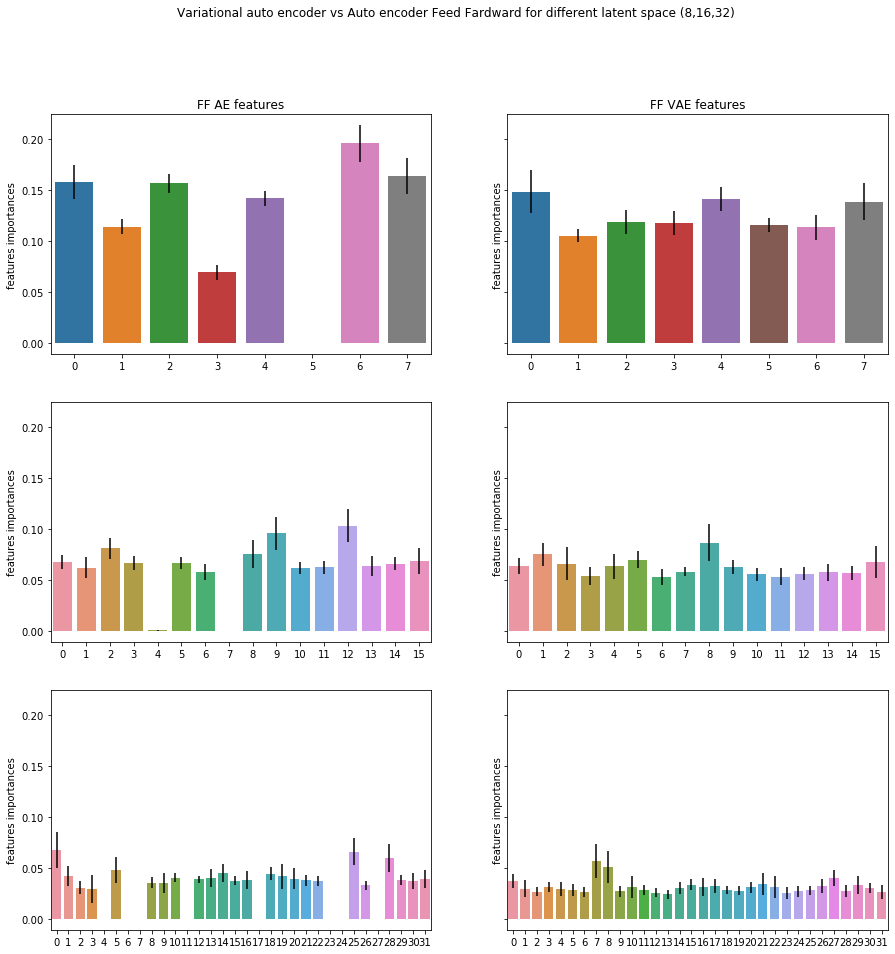

In [63]:
plot_bar(encoder_feature_importance_ff,encoder_feature_importance_ff_sigma,title="Variational auto encoder vs Auto encoder Feed Fardward for different latent space (8,16,32)",lstm=False)

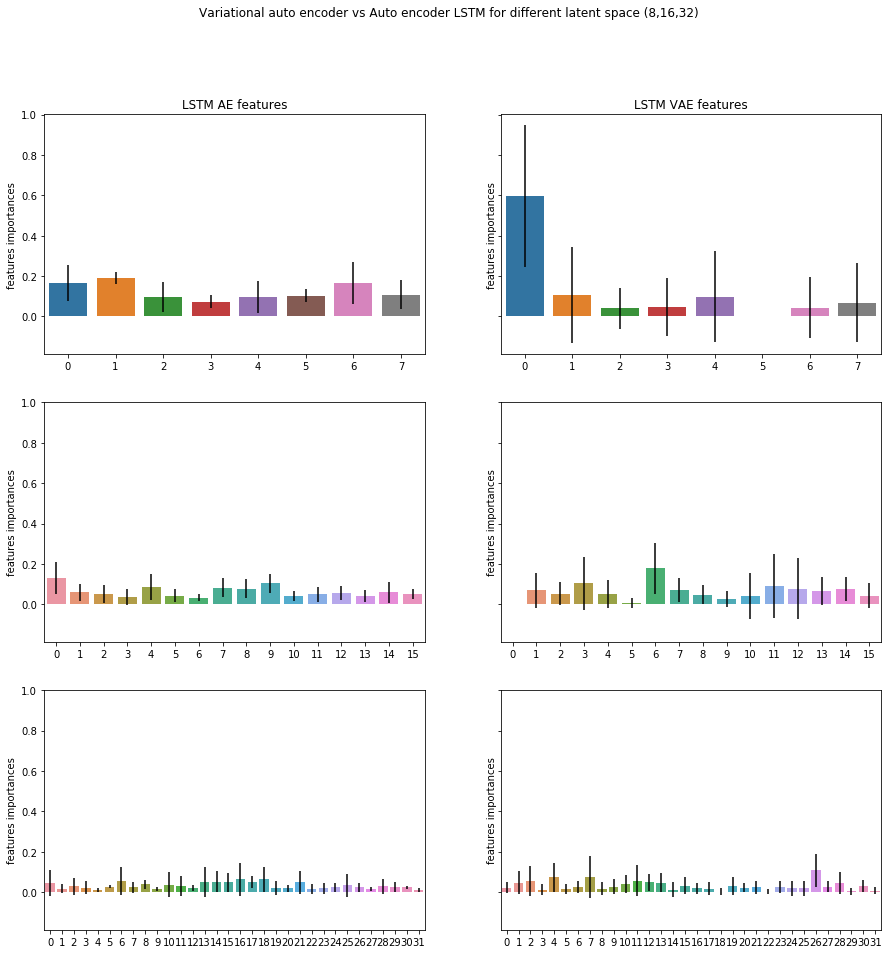

In [64]:
plot_bar(encoder_feature_importance_lstm,encoder_feature_importance_lstm_sigma,title="Variational auto encoder vs Auto encoder LSTM for different latent space (8,16,32)")